In [29]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import *
import copy

!pip install yahoo_fin

import yahoo_fin as y_f
from yahoo_fin import stock_info as si
import pickle
from numpy.linalg import inv
from pylab import plot, show
import seaborn as sns

from datetime import *
from copy import *
from datetime import date, timedelta

import statsmodels.api as sm

import sys
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)

In [2]:
url="http://yuknabungsaham.idx.co.id/indeks-lq45"
table= pd.read_html(url,header=0)
for i in table:
    i.columns = table[0].columns

listKode=pd.concat(table[0:len(table)],sort=True).reset_index()

Stock_Code = listKode['Kode']  + ".JK"

#To Download all data will takes time, sometime it would be better to download upload from gdrive
# We would like all available data from 01/01/1990.
start_date = '1990-01-01'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
LQ45 = data.DataReader('^JKLQ45', 'yahoo', start_date)

# panel_data
panel_data = data.DataReader(Stock_Code, 'yahoo', start_date)
panel_data = panel_data.dropna(how="all")

#Market Cap Data
quote = {}
for i in Stock_Code:
  quote[i] = si.get_quote_table(i)


In [3]:

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [4]:
def mean_reversion(Series, mode={'c','ct', None}, lag=int(1)):
  def pct_change(array,lag):
    return Series[lag:] - Series[:-lag]
  
  Y = pct_change(Series,lag)
  X = Series[:-lag]
  if mode == 'c':
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    adf_value = results.tvalues[1]
    half_life = -np.log(2)/results.params[1]
    lamb = results.params[1]
    pvalue = results.pvalues[1]
    constant = results.params[0]
    trending = 0

  elif mode == 'ct':
    X = sm.add_constant(X)
    Trend = np.array(range(len(Series)-lag))
    X = np.append(X,Trend.reshape(-1,1),axis=1)
    model = sm.OLS(Y,X)
    results = model.fit()
    adf_value = results.tvalues[1]
    half_life = -np.log(2)/results.params[1]
    lamb = results.params[1]
    pvalue = results.pvalues[1]
    constant = results.params[0]
    trending = results.params[2]
  elif mode == 't':
    Trend = np.array(range(len(Series)-lag))
    X = np.append(X.reshape(-1,1),Trend.reshape(-1,1),axis=1)
    model = sm.OLS(Y,X)
    results = model.fit()
    adf_value = results.tvalues[0]
    half_life = -np.log(2)/results.params[0]
    lamb = results.params[0]
    pvalue = results.pvalues[0]
    constant = 0
    trending = results.params[1]

  elif mode == None:
    X = X.reshape(-1,1)
    model = sm.OLS(Y,X)
    results = model.fit()
    adf_value = results.tvalues[0]
    half_life = -np.log(2)/results.params[0]
    lamb = results.params[0]
    pvalue = results.pvalues[0]
    constant = 0
    trending = 0


  # E_V = Series[-1]*np.exp(lamb*np.array(range(len(Series)-lag))) - constant/lamb * (1 -np.exp(lamb*np.array(range(len(Series)-lag)))) - (trending*np.array(range(len(Series)-lag)))/lamb
  # # plt.plot(np.append(Series,E_V))

  return [lamb,constant,trending,adf_value, pvalue, half_life]

def Hurst_Test(ts,lags = range(1, 35)):
  tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
  # plot(log(lags), log(tau)); show()
  m = polyfit(log(lags), log(tau), 1)
  hurst = m[0]*2.0
  # print(hurst)
  return hurst


In [5]:
#Markov
def Markov_Test(df): 
  Weekly_Returns = df.pct_change().dropna()
  Negative_Returns = pd.DataFrame(Weekly_Returns[Weekly_Returns<0])
  Positive_Returns = pd.DataFrame(Weekly_Returns[Weekly_Returns>0])
  # Negative_Returns
  Quantile_Negative = Negative_Returns.describe()
  Quantile_Positive = Positive_Returns.describe()

  Weekly_Returns = pd.DataFrame(Weekly_Returns)
  Weekly_Returns.columns = ['Returns']
  Weekly_Returns['Returns_Quantile'] = 0

  Weekly_Returns.loc[Weekly_Returns['Returns'].values>=Quantile_Negative.values[-5],('Returns_Quantile')] =1
  Weekly_Returns.loc[Weekly_Returns['Returns'].values>=Quantile_Negative.values[-4],('Returns_Quantile')] =2
  Weekly_Returns.loc[Weekly_Returns['Returns'].values>=Quantile_Negative.values[-3],('Returns_Quantile')] =3
  Weekly_Returns.loc[Weekly_Returns['Returns'].values>=Quantile_Negative.values[-2],('Returns_Quantile')] =4
  Weekly_Returns.loc[Weekly_Returns['Returns'].values>=Quantile_Negative.values[-1],('Returns_Quantile')] =5
  Weekly_Returns.loc[Weekly_Returns['Returns'].values>=0,('Returns_Quantile')] =6
  Weekly_Returns.loc[Weekly_Returns['Returns'].values>=Quantile_Positive.values[-5],('Returns_Quantile')] =7
  Weekly_Returns.loc[Weekly_Returns['Returns'].values>=Quantile_Positive.values[-4],('Returns_Quantile')] =8
  Weekly_Returns.loc[Weekly_Returns['Returns'].values>=Quantile_Positive.values[-3],('Returns_Quantile')] =9
  Weekly_Returns.loc[Weekly_Returns['Returns'].values>=Quantile_Positive.values[-2],('Returns_Quantile')] =10

  Weekly_Returns['Returns_Quantile_NW'] = Weekly_Returns['Returns_Quantile'].shift(-1)
  Markov = pd.crosstab(Weekly_Returns['Returns_Quantile'],Weekly_Returns['Returns_Quantile_NW'])
  Markov['Total'] = Markov.sum(axis=1)
  Markov_Percentage = Markov.iloc[:,0:10].div(Markov['Total'], axis=0)
  Quantiles = np.append(np.append(Quantile_Negative[-5:].values,0),Quantile_Positive[-4:].values)
  Mean_Reversion_Probability = Markov_Percentage.iloc[:5,5:].sum(axis=1)
  return_condition = (1/(1 + Quantile_Negative[-5:].values)-1) < Quantile_Positive[-5:].values[::-1]
  return [Markov, Quantiles, Mean_Reversion_Probability, return_condition.T[0], Weekly_Returns]


In [307]:
def BackTest_Portfolio(
    Portfolio_Initial_Value,Price_data,
    Trade_Order,Outsample_Date_Range,date_hold):
  Price_data.index = Price_data.index.date
  Price_data = Price_data.iloc[Price_data.index>=Outsample_Date_Range[0],:]
  Price_data = Price_data.iloc[Price_data.index<=Outsample_Date_Range[1],:]


  Buy_Order = Trade_Order[['Symbols','Date']]
  Buy_Order['Reference'] = "Open"
  Buy_Order.columns = ['Buy_Symbols','Buy_Date','Buy_Reference']
  Buy_Order['Buy_Date'] = Buy_Order['Buy_Date'].dt.date
  Buy_Order['Sell_Date'] = (Buy_Order['Buy_Date'] + pd.DateOffset(days=date_hold)).dt.date
  Buy_Order['Sell_Reference'] = "Close"
  Buy_Order['Weight'] = 0.1
  Buy_Order = Buy_Order[Buy_Order.Buy_Date.isin(Price_data.index) & Buy_Order.Sell_Date.isin(Price_data.index)]

  Price_data=Price_data.interpolate()

  x=0
  Portfolio_Value = np.zeros(((int((Outsample_Date_Range[1] - Outsample_Date_Range[0]).days)),3))
  Portfolio_Value[0,1] = Portfolio_Initial_Value
  Buy_Ticker = np.array(['']*int((Outsample_Date_Range[1] - Outsample_Date_Range[0]).days),dtype='object')
  Sell_Ticker = np.array(['']*int((Outsample_Date_Range[1] - Outsample_Date_Range[0]).days),dtype='object')
  Ticker_List = Price_data['Close'].columns
  Ticker_Close_Price = np.zeros((int((Outsample_Date_Range[1] - Outsample_Date_Range[0]).days),len(Ticker_List)))
  Ticker_Open_Price = copy.deepcopy(Ticker_Close_Price)
  Order_Ticker = copy.deepcopy(Ticker_Close_Price)
  Outstanding_Ticker = copy.deepcopy(Ticker_Close_Price)
  Lot_Size = copy.deepcopy(Ticker_Close_Price)
  date = np.array(['']*int((Outsample_Date_Range[1] - Outsample_Date_Range[0]).days),dtype='object')

  for i in daterange(Outsample_Date_Range[0],Outsample_Date_Range[1]):
    date[x] = i
    if Price_data.loc[Price_data.index == i,:].values.any():
      Ticker_Close_Price[x,:] = Price_data.loc[Price_data.index == i,'Close'].values
      Ticker_Open_Price[x,:] = Price_data.loc[Price_data.index == i,'Open'].values
    else :
      Ticker_Close_Price[x,:] = 0
      Ticker_Open_Price[x,:] = 0
    Buy_Ticker[x] = Buy_Order.loc[Buy_Order['Buy_Date'] == i,'Buy_Symbols'].values
    Sell_Ticker[x] = Buy_Order.loc[Buy_Order['Sell_Date'] == i,'Buy_Symbols'].values
    a = [+1 if y in Buy_Ticker[x] else 0 for y in Ticker_List]
    b = [-1 if y in Sell_Ticker[x] else 0 for y in Ticker_List]
    Outstanding_Ticker[x] = Outstanding_Ticker[x-1] + a + b
    # if x==32:
    #   print(any([x==1 for x in a]),any([x==-1 for x in b]),any(Outstanding_Ticker[x]==1),x>0)
    #   print(Lot_Size[x])
    #   print(i)
    #   print(Ticker_Close_Price[x,:])
    #   print(np.nansum(Lot_Size[x-1]*Ticker_Close_Price[x,:]))
    #   if any(Outstanding_Ticker[x]==1) :
    #     print('a')
    #   elif x>0 :
    #     print('b')

    if any([x==1 for x in a]) :
      Lot_Size[x,[x==1 for x in a]] = (Portfolio_Value[x-1,1]*0.996 / sum(a)) // (Ticker_Open_Price[x,[y in Buy_Ticker[x] for y in Ticker_List]]*100)*100
      Portfolio_Value[x,1] = Portfolio_Value[x-1,1] - np.nansum(Lot_Size[x]*Ticker_Open_Price[x,:]) - np.nansum(Lot_Size[x]*Ticker_Open_Price[x,:]) *.0015    
      Portfolio_Value[x,0] = np.nansum(Lot_Size[x]*Ticker_Open_Price[x,:])
      Portfolio_Value[x,2] = - np.nansum(Lot_Size[x]*Ticker_Open_Price[x,:]) *.0015    
      # if x<30:
      #   print(Lot_Size[x],Ticker_Open_Price[x,:])
      #   print(Lot_Size[x] * Ticker_Open_Price[x,:])
      #   print(np.nansum(Lot_Size[x] * Ticker_Open_Price[x,:]))
      #   print(i)
    elif any([x==-1 for x in b]) :
      Lot_Size[x,[x==-1 for x in b]] = 0
      Portfolio_Value[x,1] = Portfolio_Value[x-1,1] + np.nansum(Lot_Size[x-1]*Ticker_Close_Price[x,:]) - np.nansum(Lot_Size[x-1]*Ticker_Close_Price[x,:]) * .0025
      Portfolio_Value[x,0] = 0
      Portfolio_Value[x,2] = - np.nansum(Lot_Size[x-1]*Ticker_Close_Price[x,:]) * .0025
      # if x<15:
      #   print(Lot_Size[x-1],Ticker_Open_Price[x,:])
      #   print(Lot_Size[x-1] * Ticker_Open_Price[x,:])
      #   print((Lot_Size[x-1] * Ticker_Open_Price[x,:]).sum())
      #   print(i)
    elif any(Outstanding_Ticker[x]==1) :
      Lot_Size[x,:] = Lot_Size[x-1,:]
      Portfolio_Value[x,1] = Portfolio_Value[x-1,1]
      if i in Price_data.index :
        Portfolio_Value[x,0] = np.nansum(Lot_Size[x]*Ticker_Open_Price[x,:])
      else :
        Portfolio_Value[x,0] = Portfolio_Value[x-1,0]
    elif x>0 :
      Portfolio_Value[x,1] = Portfolio_Value[x-1,1]
      Portfolio_Value[x,0] = 0
    # print(sum(Portfolio_Value[x]))
    x = x + 1
    
  Portfolio_Value = pd.DataFrame(Portfolio_Value)
  Portfolio_Value.columns = ["Portfolio_Value","Cash","Transaction_Fee"]
  Portfolio_Value.index = date
  plt.figure(figsize=(20,10))
  (Portfolio_Value.iloc[:,:2].sum(axis=1)/1000).plot()
  return Portfolio_Value



In [7]:
def quantile_marking(Quantiles,df,Conditions,Markov_Expected_Return):
  df["Returns_Quantile"] = 0
  df.loc[df.iloc[:,0].values>=Quantiles[0],('Returns_Quantile')] =1
  df.loc[df.iloc[:,0].values>=Quantiles[1],('Returns_Quantile')] =2
  df.loc[df.iloc[:,0].values>=Quantiles[2],('Returns_Quantile')] =3
  df.loc[df.iloc[:,0].values>=Quantiles[3],('Returns_Quantile')] =4
  df.loc[df.iloc[:,0].values>=Quantiles[4],('Returns_Quantile')] =5
  df.loc[df.iloc[:,0].values>=Quantiles[5],('Returns_Quantile')] =6
  df.loc[df.iloc[:,0].values>=Quantiles[6],('Returns_Quantile')] =7
  df.loc[df.iloc[:,0].values>=Quantiles[7],('Returns_Quantile')] =8
  df.loc[df.iloc[:,0].values>=Quantiles[8],('Returns_Quantile')] =9
  df.loc[df.iloc[:,0].values>=Quantiles[9],('Returns_Quantile')] =10
  Trade_Order = pd.DataFrame([df[[x in Conditions for x in df['Returns_Quantile']]].index,df[[x in Conditions for x in df['Returns_Quantile']]]['Returns_Quantile'].values,
                              Markov_Expected_Return[df[[x in Conditions for x in df['Returns_Quantile']]]['Returns_Quantile'].values].values]).T
  Trade_Order.columns = ["Date","Quantiles",'Expected_Return']
  Trade_Order['Symbols'] = df.columns[0]
  Trade_Order['Code'] = Trade_Order.Date.dt.strftime('%Y') + Trade_Order.Date.dt.strftime('%W')  
  return Trade_Order

In [8]:

def Screener(Insample_Date_Range,Outsample_Date_Range,Ticker):
  # print(Ticker)
  df = panel_data['Close'][Ticker].dropna()
  # print(Ticker)
  df = df[(df.index.date >= Insample_Date_Range[0]) & (df.index.date <= Insample_Date_Range[1])]
  df = df[df.index.dayofweek==2]
  # print(df.shape)
  if not (df.empty or df.shape[0]<30) :
    Series = df.dropna().pct_change().dropna().values
    MR_Test = mean_reversion(Series,mode="c",lag =1)
    ts = df.values
    lags = range(1, 20)
    H_Test = Hurst_Test(ts,lags)
    # calculate Hurst as slope of log-log plot
    Markov_Result = Markov_Test(df)
    Markov_Return = np.mean([Markov_Result[1][1:],Markov_Result[1][:-1]],axis=0)
    Markov_Return = np.append(Markov_Return,Markov_Result[1][-1])
    Markov_Return[:4] = 1 - (1/(1 + Markov_Return[:4]))
    # print(Markov_Return)
    # print(Markov_Result[0].iloc[:,:-1].columns-1)
    # print(np.take(Markov_Return,Markov_Result[0].iloc[:,:-1].columns-1))
    Markov_Expected_Return = Markov_Result[0].iloc[:,:-1].multiply(np.take(Markov_Return,Markov_Result[0].iloc[:,:-1].columns-1),axis=1).mean(axis=1)
    Markov_Expected_Return = pd.Series(Markov_Expected_Return,index = range(1,Markov_Expected_Return.index[-1]))
    Markov_Expected_Return = Markov_Expected_Return.interpolate()
    if not np.isnan(Markov_Result[1]).any():
      Weekly_Returns = Markov_Result[4]
      # M_Test = (Markov_Result[2]>0.5).values & Markov_Result[3]
      
      Condition_1 = [MR_Test[0]<0,MR_Test[4]<0.05,H_Test<0.4]
      Condition_2 = np.where(np.logical_and((Markov_Expected_Return>0).values, Markov_Expected_Return.index <6))[0]+1
      # print(Condition_2)
      Screen_Stock = np.all(Condition_1) & np.any(Markov_Expected_Return>0)
      # print(Ticker, Condition_1,M_Test)
      if Screen_Stock :
        df_os = panel_data['Close'][Ticker].dropna()
        df_os = df_os[(df_os.index.date >= Outsample_Date_Range[0]) & (df_os.index.date <= Outsample_Date_Range[1])]
        df_os = df_os[df_os.index.dayofweek==2]
        df_pct = df_os.pct_change()
        # print(df_pct)
        Trade_Order = quantile_marking(Markov_Result[1],df_pct.to_frame(),Condition_2,Markov_Expected_Return)
        return Trade_Order

In [192]:
#In Function Form Cannonical Formula

def BL_Portfolio(Market_Returns,Market_Weights,rfr,covariance,tau,Views):
  
  Q = Views[0]
  P = Views[1]

  excess_asset_returns = Market_Returns.subtract(rfr, axis=0)
  covariance = excess_asset_returns.cov().values
  global_return = excess_asset_returns.mean(axis=0).multiply(Market_Weights).sum()
  market_var = Market_Weights.T @ covariance @ Market_Weights

  # print(f'The global market mean return is {global_return:.4f} and the variance is {market_var:.6}')
  risk_aversion = global_return / market_var
  # print(f'The risk aversion parameter is {risk_aversion:.2f}')
  
  implied_equilibrium_returns = risk_aversion * covariance.dot(Market_Weights).squeeze()

  sigma_scaled = covariance * tau
  
  omega = np.diag(np.diag(   (P @ (sigma_scaled) @ P.T )   ))
  # print(f'Omega is  {omega}')

 
  BL_return_vector =  implied_equilibrium_returns + sigma_scaled @ P.T @ inv(
                      P @ sigma_scaled @ P.T + omega) @(
                      Q - P @ implied_equilibrium_returns)

  # BL_return_vector_Original_Formula =  inv(inv(sigma_scaled) + P.T @ inv(omega) @ P) @ (
  #     inv(sigma_scaled) @ implied_equilibrium_returns + P.T @ inv(omega) @ Q)

  BL_Posterior_Covariance =  inv(inv(sigma_scaled) + P.T @ inv(omega) @ P)

  BL_Final_Covariance =  covariance + BL_Posterior_Covariance

  BL_weights_vector = inv(covariance * risk_aversion) @ BL_return_vector

  BL_weights_vector = BL_weights_vector/sum(BL_weights_vector)

  return BL_return_vector, BL_Posterior_Covariance, BL_Final_Covariance, BL_weights_vector


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

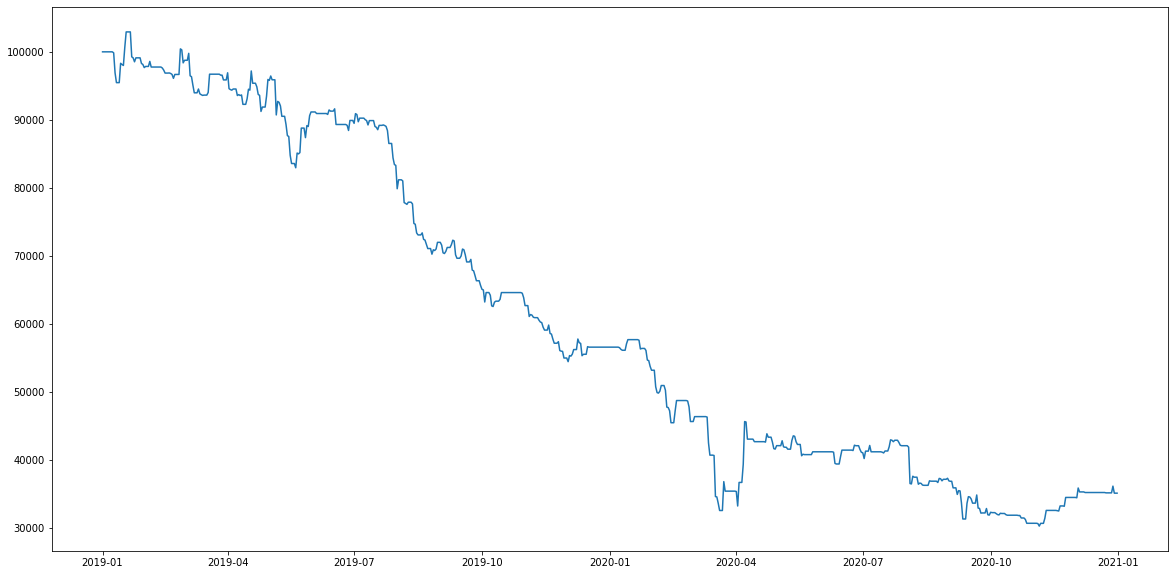

In [326]:

df = panel_data['Close'].dropna()
Ticker = df.columns
# print(Ticker)
Insample_Date_Range = np.array([date(2013,1,1),date(2019,1,1)])
Outsample_Date_Range = np.array([date(2019,1,1),date(2021,1,1)])
order_list = [Screener(Insample_Date_Range,Outsample_Date_Range,x) for x in Ticker]
Trade_Order = pd.concat(order_list)
# print(Trade_Order)
Backtest_Result = BackTest_Portfolio(1 * 10**8,copy.deepcopy(panel_data),Trade_Order,Outsample_Date_Range,date_hold=6)
# Trade_Order

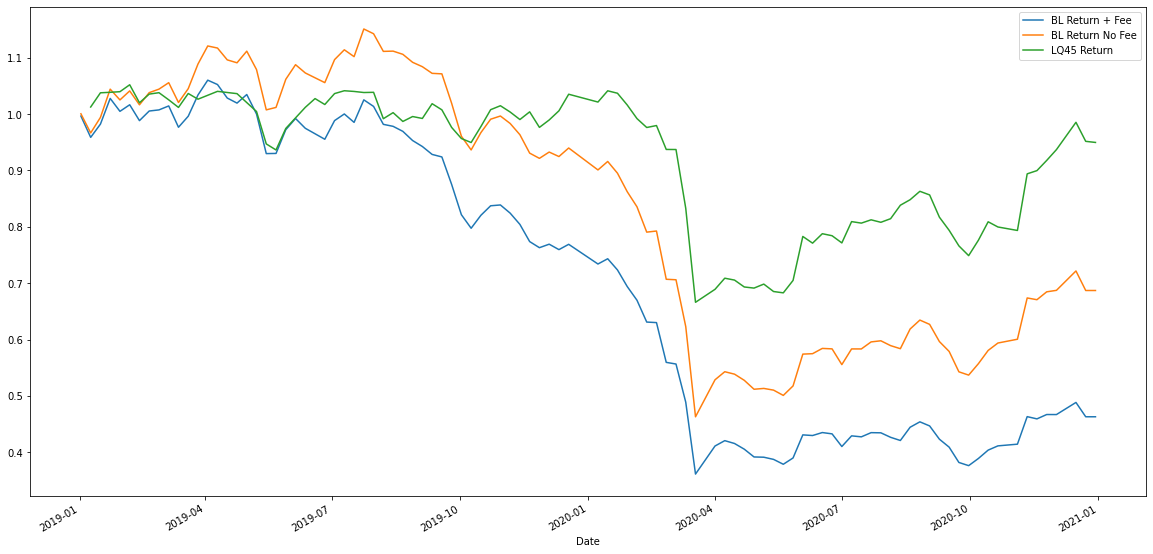

In [327]:
plt.figure(figsize=(20,10))
# Trade_Order.sort_values(['Date'])
Asset_Price = copy.deepcopy(panel_data['Close'].dropna(how="any"))

Insample_Asset = Asset_Price.iloc[Asset_Price.index.date>=Insample_Date_Range[0],:]
Insample_Asset = Asset_Price.iloc[Asset_Price.index.date<=Insample_Date_Range[1],:]
Insample_Asset = Insample_Asset[Insample_Asset.index.dayofweek==2]
Insample_Asset_Return = Insample_Asset.pct_change().dropna(how="any")

covariance = Insample_Asset_Return.cov()
rfr = .067/252*5
tau = 1/(Insample_Asset.shape[0] - Insample_Asset.shape[1])
Order_List = Trade_Order

Asset_Price = Asset_Price.iloc[Asset_Price.index.date>=Outsample_Date_Range[0],:]
Asset_Price = Asset_Price.iloc[Asset_Price.index.date<=Outsample_Date_Range[1],:]

Asset_Price = Asset_Price[Asset_Price.index.dayofweek==2]
Asset_Return = Asset_Price.pct_change().shift(-1).dropna()

stock_Dict = [None] * len(Asset_Price.index.date)
Portfolio_Returns = np.zeros(len(Asset_Price.index.date))
for i in range(len(Asset_Price.index.date)-1):
  stock_Dict[i] = Order_List[Order_List['Date'].dt.date.values == Asset_Price.index.date[i]]
  # print(Asset_Price.index.date[i])
  # print(Order_List['Date'].dt.date.values)
  if(len(stock_Dict[i])>0):
    Q = stock_Dict[1]['Expected_Return'].values - rfr
    # print(Q)
    P = np.zeros((len(Q),Asset_Returns.shape[1]))
    # Asset_Price.columns in stock_Dict[1]['Symbols']
    Bool = [Asset_Price.columns == x for x in stock_Dict[1]['Symbols']]
    for x in range(len(P)) :
      P[x][Bool[x]] = 1 
    Views = [Q,P]
    BL_return_vector, BL_Posterior_Covariance, BL_Final_Covariance, BL_weights_vector = BL_Portfolio(Insample_Asset_Return,Market_Weight['Weight'].values,rfr,covariance,tau,Views)
    # print(BL_weights_vector)
    Portfolio_Returns[i] = BL_weights_vector @ Asset_Return.iloc[i-1,:]-0.004
  else: 
    Portfolio_Returns[i] = Market_Weight['Weight'] @ Asset_Return.iloc[i-1,:]-0.004
# print((stock_Dict))
Portfolio_Returns = pd.DataFrame(Portfolio_Returns,Asset_Price.index.date)

Portfolio_Returns['Cum_Returns'] = (1 + Portfolio_Returns[0]).cumprod()
Portfolio_Returns['Cum_Returns'].plot(label = 'BL Return + Fee')

Portfolio_Returns_1 = Portfolio_Returns

stock_Dict = [None] * len(Asset_Price.index.date)
Portfolio_Returns = np.zeros(len(Asset_Price.index.date))
for i in range(len(Asset_Price.index.date)-1):
  stock_Dict[i] = Order_List[Order_List['Date'].dt.date.values == Asset_Price.index.date[i]]
  if(len(stock_Dict[i])>0):
    Q = stock_Dict[1]['Expected_Return'].values - rfr
    P = np.zeros((len(Q),Asset_Returns.shape[1]))
    # Asset_Price.columns in stock_Dict[1]['Symbols']
    Bool = [Asset_Price.columns == x for x in stock_Dict[1]['Symbols']]
    for x in range(len(P)) :
      P[x][Bool[x]] = 1 
    Views = [Q,P]
    BL_return_vector, BL_Posterior_Covariance, BL_Final_Covariance, BL_weights_vector = BL_Portfolio(Insample_Asset_Return,Market_Weight['Weight'].values,rfr,covariance,tau,Views)
    # print(BL_weights_vector)
    Portfolio_Returns[i] = BL_weights_vector @ Asset_Return.iloc[i-1,:]
  else: 
    Portfolio_Returns[i] = Market_Weight['Weight'] @ Asset_Return.iloc[i-1,:]

Portfolio_Returns = pd.DataFrame(Portfolio_Returns,Asset_Price.index.date)

Portfolio_Returns['Cum_Returns'] = (1 + Portfolio_Returns[0]).cumprod()
Portfolio_Returns['Cum_Returns'].plot(label = 'BL Return No Fee')

Portfolio_Returns_2 = Portfolio_Returns

LQ45_Close = LQ45['Close']
LQ45_Close.index.date>=Outsample_Date_Range[0]
LQ45_Close = LQ45_Close.iloc[LQ45_Close.index.date>=Outsample_Date_Range[0]]
LQ45_Close = LQ45_Close.iloc[LQ45_Close.index.date<=Outsample_Date_Range[1]]
LQ45_Close = LQ45_Close[LQ45_Close.index.dayofweek==2]
(1 + LQ45_Close.pct_change()).cumprod().plot(label = 'LQ45 Return')
LQ45_Close = pd.DataFrame(LQ45_Close)
LQ45_Close['Cum_Returns'] = (1 + LQ45_Close.pct_change()).cumprod()

# Portfolio_EQW_Return = Asset_Return @ Market_Weight['Weight']
# ((1 + Portfolio_EQW_Return).cumprod()-0.004).plot(label = 'Portfolio EQW Return')


plt.legend()

In [329]:
Returns = pd.DataFrame([Portfolio_Returns_1.iloc[-1,1],
Portfolio_Returns_2.iloc[-1,1],
LQ45_Close.iloc[-1,1]],['BL Return + Fee','BL Return No Fee','LQ45 Return'])
Returns.columns=["Final Value after 2 years"]
Returns

,Final Value after 2 years
BL Return + Fee,0.462920
BL Return No Fee,0.687001
LQ45 Return,0.949754
